In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV

%precision %.7g
%matplotlib inline

# KNN

## 1. Explore

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

## 2. Build and Evaluate Model

In [3]:
predictors = ["BMI", "BloodPressure"]
X = data[predictors]
y = data["Outcome"]

n_neighbors = 5

#create the model 
knn = KNeighborsClassifier(n_neighbors = n_neighbors)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

#standardize the variables
z = StandardScaler()
z.fit(X_train)
Xz_train = z.transform(X_train)
Xz_test = z.transform(X_test)

#fit the model
knn.fit(Xz_train,y_train)


KNeighborsClassifier()

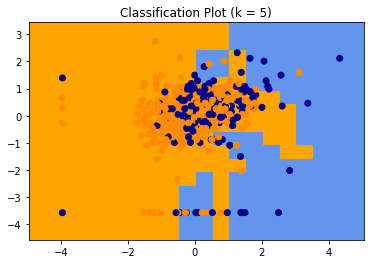

In [39]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plotKNN(X,y, title, n_neighbors, model):
    #adapted from: https://pythonspot.com/k-nearest-neighbors/
    h = .5  # step size in the mesh
    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])
    # calculate min, max and limits
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))

    # predict class using data and kNN classifier
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Classification Plot (k = %i)" % (n_neighbors))
    plt.show()
    
    
plotKNN(X = Xz_train,y = y_train, title = "KNN", n_neighbors = n_neighbors, model = knn)

In [40]:
knn.score(Xz_test,y_test) #accuracy

0.6363636363636364

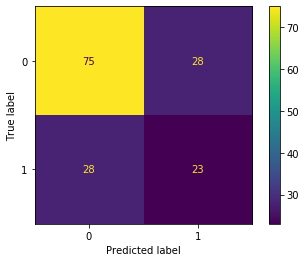

In [41]:
plot_confusion_matrix(knn, Xz_test, y_test)

# Parameter Tuning

## Option 1: By Hand

In [4]:
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

#split again using the original split for the validation set
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2)

#possible k values
poss_k = [1,2,3,4,5,6,7,8,9,10]
acc = {} #dictionary instead of list

for k in poss_k:
    #build a model
    knn3 = KNeighborsClassifier(n_neighbors = k)
    #fit the model using the actual train set
    knn3.fit(X_train2,y_train2)
    #store the accuracy of the model in the dictionary
    acc[k] = knn3.score(X_val,y_val)
print(acc)

chosen_k = max(acc, key=acc.get) #what is the key with highes accuracy
print(chosen_k)

#build a final model that will be evaluated by the test set
knn_final = KNeighborsClassifier(n_neighbors = chosen_k)
knn_final.fit(X_train,y_train)

#finally touching the test set
knn_final.score(X_test,y_test)

{1: 0.5447154471544715, 2: 0.5609756097560976, 3: 0.5772357723577236, 4: 0.6016260162601627, 5: 0.5934959349593496, 6: 0.6016260162601627, 7: 0.5609756097560976, 8: 0.6097560975609756, 9: 0.5853658536585366, 10: 0.5934959349593496}
8


0.6558441558441559

## Option 2: By hand (but make it k-fold)

In [5]:
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

poss_k = [1,2,3,4,5,6,7,8,9,10]
acc = {}

for k in poss_k:
    kf = KFold(n_splits = 5)
    knn3 = KNeighborsClassifier(n_neighbors = k)
    
    #cross_val_score gives the list of accuracies when we do 5 fold cross val
    acc[k] = np.mean(cross_val_score(knn3, X_train, y_train, cv = kf))

print(acc)

#choose highest accuracy 
chosen_k = max(acc, key=acc.get)
print(chosen_k)

#fit the model with ALL training data
knn_final = KNeighborsClassifier(n_neighbors = chosen_k)
knn_final.fit(X_train,y_train)

#evaluate the model on the testing data
knn_final.score(X_test,y_test)

{1: 0.5815007330401173, 2: 0.6302279088364655, 3: 0.5863654538184726, 4: 0.6026389444222311, 5: 0.6123683859789417, 6: 0.6156604025056645, 7: 0.6238171398107424, 8: 0.6303478608556576, 9: 0.6091430094628816, 10: 0.6173264027722245}
8


0.6623376623376623

## Option 3 (recommended): Grid Search

In [6]:
# what K do I use??

predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# choose potential values of k
ks = {"n_neighbors": range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(knn2,ks, scoring = "accuracy", cv = 5)

#run the model validation for us and be the best fit model already
knnmod = grid.fit(X_train, y_train)

In [45]:
#from your best model, get your best parameters (value of k)
knnmod.best_estimator_.get_params()["n_neighbors"]

29

In [7]:
# highest accuracy pulled from the model
knnmod.best_score_
# more things you can pull: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

0.6612288417966147

In [8]:
#how well does our model do on unseen data
knnmod.score(X_test,y_test)

0.5844155844155844